In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 100000000)
import warnings



In [2]:
df = pd.read_csv('prueba.csv')


In [4]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [6]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()

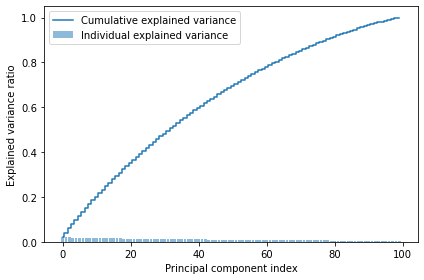

In [7]:
# Ho many components do we need 
from sklearn.decomposition import PCA
pca = PCA()
X_sc = sc.fit_transform(X)
X_train_pca = pca.fit_transform(X_sc)

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
# De acuerdo al plot de PCA, para poder explicar más del 50% de la varianza necesitamos el al menos 50 componentes

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)
pca_50 = PCA(n_components=50)
X_train_sc_pca = pca_50.fit_transform(X_train_sc)

X_test_sc_pca = pca_50.fit_transform(X_test_sc)

In [17]:
# Model Selection
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.data import mnist_data
from sklearn.metrics import accuracy_score

# Initializing Classifiers
#clf1 = LogisticRegression(
#                          solver='newton-cg',
#                          random_state=1)
clf2 = KNeighborsClassifier(algorithm='ball_tree',
                            leaf_size=50)
clf3 = DecisionTreeClassifier(random_state=1)
#clf4 = SVC(random_state=1)
clf5 = RandomForestClassifier(random_state=1)

# Building the pipelines
#pipe1 = Pipeline([('std', StandardScaler()),
#                  ('clf1', clf1)])

pipe2 = Pipeline([('std', StandardScaler()),
                  ('clf2', clf2)])

#pipe4 = Pipeline([('std', StandardScaler()),
#                  ('clf4', clf4)])


# Setting up the parameter grids
#param_grid1 = [{'clf1__penalty': ['l2'],
#                'clf1__C': np.power(10., np.arange(-4, 4))}]

param_grid2 = [{'clf2__n_neighbors': list(range(1, 10)),
                'clf2__p': [1, 2]}]

param_grid3 = [{'max_depth': list(range(1, 10)) + [None],
                'criterion': ['gini', 'entropy']}]

#param_grid4 = [{'clf4__kernel': ['rbf'],
#                'clf4__C': np.power(10., np.arange(-4, 4)),
#                'clf4__gamma': np.power(10., np.arange(-5, 0))},
#               {'clf4__kernel': ['linear'],
#                'clf4__C': np.power(10., np.arange(-4, 4))}]

param_grid5 = [{'n_estimators': [10, 100, 500, 1000, 10000]}]

In [18]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid2, param_grid3, param_grid5),
                            (pipe2, clf3, clf5),
                            ('KNN', 'DTree', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [19]:
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        gridcvs[name].fit(X_train[train_idx], y_train[train_idx]) # run inner loop hyperparam tuning
        print('\n        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        # perf on test fold (valid_idx)
        outer_scores.append(gridcvs[name].best_estimator_.score(X_train[valid_idx], y_train[valid_idx]))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        Best ACC (avg. of inner test folds) 48.21%
        Best parameters: {'criterion': 'gini', 'max_depth': 5}
        ACC (on outer test fold) 55.71%

        Best ACC (avg. of inner test folds) 48.93%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}
        ACC (on outer test fold) 54.29%

        Best ACC (avg. of inner test folds) 49.64%
        Best parameters: {'criterion': 'gini', 'max_depth': 1}
        ACC (on outer test fold) 51.43%

        Best ACC (avg. of inner test folds) 55.36%
        Best parameters: {'criterion': 'gini', 'max_depth': 5}
        ACC (on outer test fold) 48.57%

        Best ACC (avg. of inner test folds) 55.00%
        Best parameters: {'criterion': 'gini', 'max_depth': None}
        ACC (on outer test fold) 55.71%

    Outer Loop:
        ACC 53.14% +/- 2.77
-------------------------------------------------- 

Algorithm: KNN
    Inner loop:

      

In [10]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train_sc_pca, y_train)

print('Training accuracy:', np.mean(model.predict(X_train_sc_pca) == y_train)*100)
print('Test accuracy:', np.mean(model.predict(X_test_sc_pca) == y_test)*100)

Training accuracy: 71.71428571428572
Test accuracy: 51.33333333333333


In [11]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(model, 
           k_features="best", # or (1, 13) and then select by hand 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs1 = sfs1.fit(X_train_sc_pca, y_train)

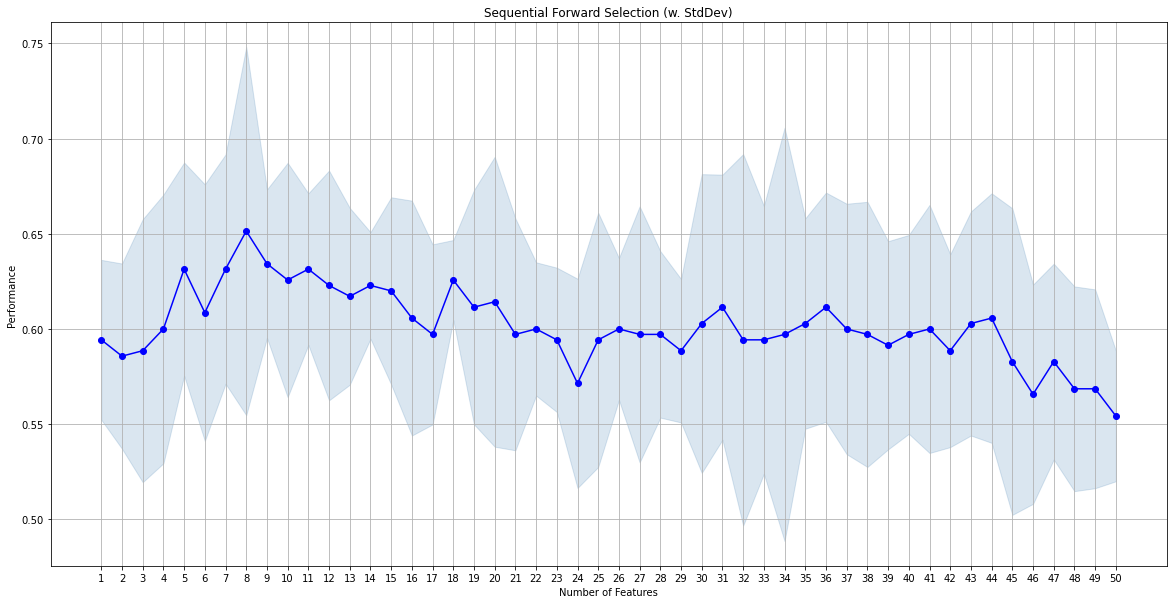

In [12]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
metric_dict = sfs1.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict, kind='std_dev',figsize=(20,10))



plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()

plt.show()

In [13]:
sfs1.k_feature_idx_

(2, 11, 20, 22, 32, 38, 46, 48)

In [14]:
sfs1.k_feature_names_

('2', '11', '20', '22', '32', '38', '46', '48')

In [16]:
X_train_pca.shape

(500, 100)